In [32]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
import datetime
import time

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
init_notebook_mode(connected=True)

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import progressbar

import seaborn as sns

In [33]:
######## Parameters #########

with open('/Users/chengdaoyang/Documents/Personal/Token/mapbox') as fp:
    mapbox_access_token = fp.readline()


######## Parameters #########

In [34]:

######## Function Start ########


def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max



def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
    
    

    
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)

    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))

    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]

        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)

        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
######## Function End ########

loading data

In [35]:
## 自己的 geopandas + plotly 去 centroid

taxi_zone_map = gpd.read_file('Data/taxi_zones/taxi_zones.shp')
taxi_zone_map_geo = taxi_zone_map.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
print(taxi_zone_map.iloc[0].geometry.centroid.y, taxi_zone_map_geo.iloc[0].geometry.centroid.y)

191376.74953083202 40.691839452780165


In [36]:
incomplete_zone_distance_matrix = pd.read_csv('./Data/zone_distance_matrix.csv', index_col=0)
zone_distance_matrix = pd.read_csv('./Data/full_zone_distance_matrix.csv', index_col=0)
zone_distance_matrix = zone_distance_matrix.iloc[1:,1:]
zone_distance_matrix.shape

(264, 264)

In [37]:
## 网上找的  
##https://chih-ling-hsu.github.io/2018/05/14/NYC
sf = shapefile.Reader("Data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,zone,longitude,latitude
0,1,1,0.000782,0.116357,EWR,Newark Airport,9.366817e+05,190522.130278
1,2,2,0.004866,0.433470,Queens,Jamaica Bay,1.033536e+06,161853.982300
2,3,3,0.000314,0.084341,Bronx,Allerton/Pelham Gardens,1.027136e+06,254730.010849
3,4,4,0.000112,0.043567,Manhattan,Alphabet City,9.904240e+05,203100.040432
4,5,5,0.000498,0.092146,Staten Island,Arden Heights,9.321332e+05,139954.541936


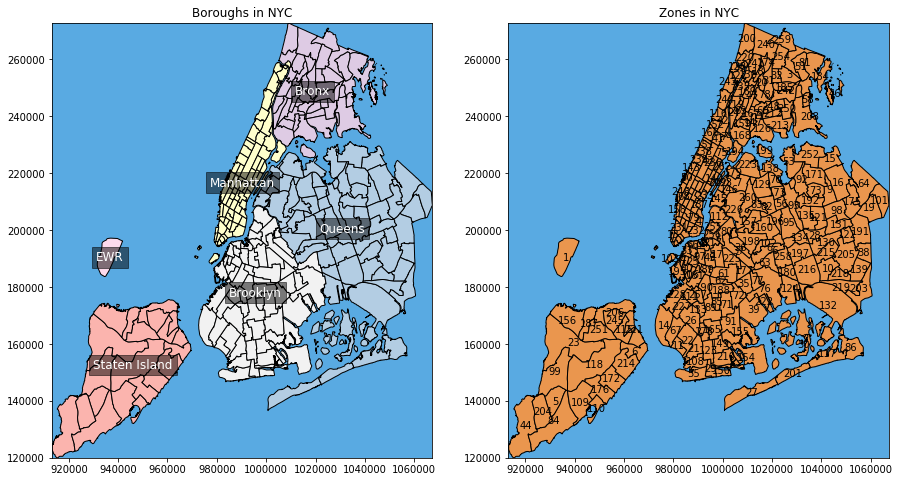

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

In [39]:
data = [
    go.Scattermapbox(
        lon=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0])],
        lat=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0])],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[i],
    )
    for i in range(taxi_zone_map_geo.shape[0]      -      200)]


layout = go.Layout(
    width=1000,
    height=600,
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lon=taxi_zone_map_geo['geometry'][28].centroid.xy[0][0],
            lat=taxi_zone_map_geo['geometry'][28].centroid.xy[1][0]
        ),
        pitch=0,
        zoom=8
    ),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='Montreal Mapbox')

In [47]:
G=nx.Graph()

for i in range(taxi_zone_map.shape[0]):
    G.add_node(i, pos=(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0],
                      taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]))

In [48]:
rows = taxi_zone_map.shape[0]
cols = taxi_zone_map.shape[1]

for i in range(rows):
    for j in range(cols):
        if incomplete_zone_distance_matrix.iloc[i,j] == incomplete_zone_distance_matrix.iloc[i,j]:
            G.add_edge(i,j, weight=incomplete_zone_distance_matrix.iloc[i,j])


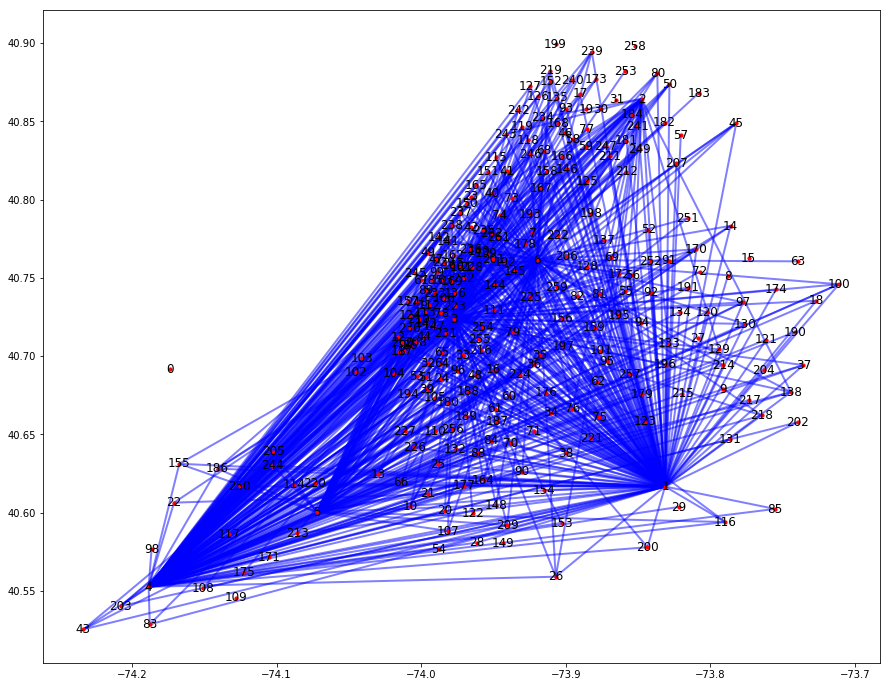

In [49]:
plt.figure(1,figsize=(15,12))

pos = nx.get_node_attributes(G, 'pos')
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=10,font_size=7,width=8,alpha=1.0)
nx.draw_networkx_edges(G,pos,font_size=7,edgelist=G.edges(),
                       width=2,alpha=0.5,edge_color='b',edge_size=2)


nx.draw_networkx_labels(G, pos)
# nx.draw(G, pos, with_labels=True, node_size=0)
plt.axis('on')
plt.show()

In [43]:

for i in range(rows):
    for j in range(cols):
        if zone_distance_matrix.iloc[i,j] == zone_distance_matrix.iloc[i,j]:
            G.add_edge(i,j, weight=zone_distance_matrix.iloc[i,j])

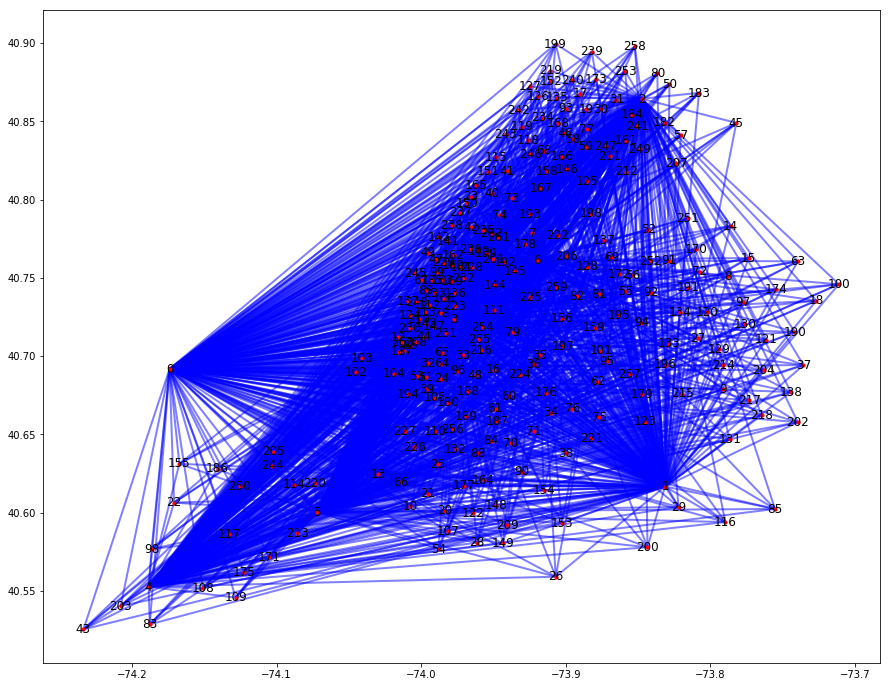

In [44]:
plt.figure(1,figsize=(15,12))

pos = nx.get_node_attributes(G, 'pos')
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=10,font_size=7,width=8,alpha=1.0)
nx.draw_networkx_edges(G,pos,font_size=7,edgelist=G.edges(),
                       width=2,alpha=0.5,edge_color='b',edge_size=2)


nx.draw_networkx_labels(G, pos)
# nx.draw(G, pos, with_labels=True, node_size=0)
plt.axis('on')
plt.show()

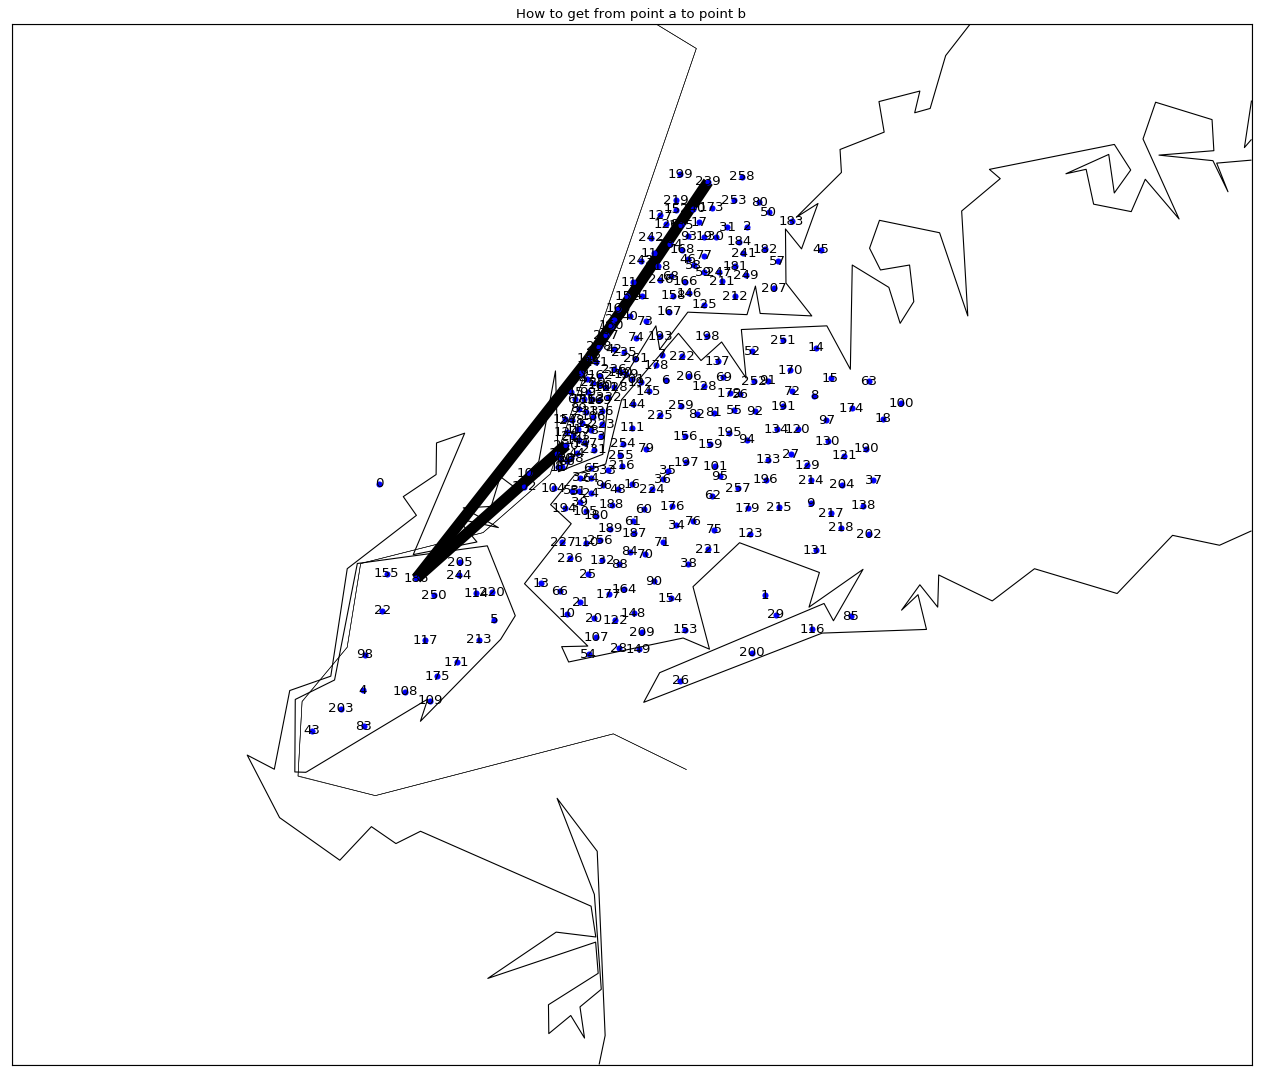

In [66]:
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
m = Basemap(
        projection='merc',
        llcrnrlon=-74.5,
        llcrnrlat=40.3,
        urcrnrlon=-73.4,
        urcrnrlat=41,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

G=nx.Graph()

for i in range(262):
    G.add_node(i, pos=m(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0],
                      taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]))


rows = taxi_zone_map.shape[0]
cols = taxi_zone_map.shape[1]

# for i in range(10):
#     for j in range(10):
#         if incomplete_zone_distance_matrix.iloc[i,j] == incomplete_zone_distance_matrix.iloc[i,j]:
#             G.add_edge(i,j, weight=incomplete_zone_distance_matrix.iloc[i,j])
            
# for i in range(42):
#     for j in range(42):
#         if zone_distance_matrix.iloc[i,j] == zone_distance_matrix.iloc[i,j]:
#             G.add_edge(i,j, weight=zone_distance_matrix.iloc[i,j])
G.add_path(b_path)
pos = nx.get_node_attributes(G, 'pos')

# draw
nx.draw_networkx(G,pos,node_size=20,node_color='blue')
nx.draw_networkx_edges(G,pos,width=10, color='yellow', arrows=True)

# draw the map
m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.drawmapboundary()
m.bluemarble()

plt.title('How to get from point a to point b')
plt.show()

In [65]:
b_path = [230,
 186,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239]

In [56]:
path = [10,
 230,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239,
 142,
 239]